In [3]:
from urllib.request import urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup, Comment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import unidecode
from googlesearch import search

mpl.rcParams['font.family'] = "serif"
mpl.rcParams['text.usetex'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = "in"
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = "in"
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]    

In [2]:
class ScrapingError(Exception):
    pass

class player:
    
    def __init__(self,name=""):
        self.name = name
        self.stat_dict = {}
        self.play_str = ""
        self.initial = ""
        self.height = None
        self.weight = None
        self.pos = None
        self.pos3 = None
        self.shoots = None
        
    def get_play_str(self,verbose=False):
        
        """Get the 'player string', associated with a player used by basketball reference in the url for all of their
        info. Generally it's the first 5 letters of the players last name and the second two of their first, plus a
        numerical counter which counts up when players have matching strings. Aliases can causes issues with this,
        e.g. Metta World Peace/Ron Artest causes an issue with matching the strings"""
        
        name = self.name
            
        name_proc = name.replace(".","")
        name_proc = name_proc.replace("'","")
        
        name_arr= name_proc.split()
        fname = name_arr[0]
        lname = ''.join(name_arr[1:])
        
        fname = fname.lower()
        lname = lname.lower()

        initial = lname[0]
        
        self.initial = initial
        
        play_num = 1
        play_count = '0' + str(play_num)

        player_found = False
        
        try:
        
            while not(player_found):
        
                url = "https://www.basketball-reference.com/players/{}/{}{}{}.html".\
                    format(initial,lname[:5],fname[:2],play_count)

                if verbose:
                    print(url)
            
                html = urlopen(url)
                soup = BeautifulSoup(html)

                #See if the player string is correct by matching the listed name to the inputted name
                name_str = unidecode.unidecode(soup.find_all('strong')[0].contents[0]) #Use unidecode to get rid of accents
                try:
                    birth_year = int(soup.find_all(id='necro-birth')[0].getText().split('\n')[-2][-4:]) #Pull player's birth year
                except IndexError:
                    birth_year = 2000
                #Also check if player is born after 1965 to avoid confusion with older players who have same name
                #Still won't help if two players have the same name in the current dataset
                if (name_str == name and birth_year > 1965):
                    if verbose:
                        print("Correct ID tag for {}".format(name))
                    player_found = True
                    self.play_str = lname[:5] + fname[:2] + play_count
                else:
                    #If this doesn't work, increment the counter at the end by 1
                    play_num += 1
                    play_count = '0' + str(play_num)
                    print("Incorrect ID tag for {}, trying counter {}".format(name,play_count))
                
                            
        except HTTPError:
            #Once we've failed at doing that, resort to just googling the player's name and basketball reference
            if verbose:
                print("Page not found, trying google")
            query = name + " basketball reference"
            strs = search(query, tld="com", num=1, stop=1)
            results = [s for s in strs]
            url = results[0]
            self.play_str = url.split('/')[-1][:-5] #Cut up url by / and pull all but last 5 chars of text after last /

            html = urlopen(url)
            soup = BeautifulSoup(html)
                
        for s in soup.find_all('p'): #Get player height and weight
            hw_stats = s.getText().find("cm")
            if hw_stats != -1:
                hw_str = s.getText()
                break
                
        for s in soup.find_all('p'):
            pos = s.getText().find("Position")
            if pos != -1:
                pos_shoots = s.getText()
                break
                    
        try:
            hw_str = hw_str.split('(')[-1] #Pull everything after the open parenses
            hw_arr = ''.join(filter(str.isdigit, hw_str)) #Pull out just the numbers

            self.height = int(hw_arr[:3]) #Assumes everyone is greater than 99 cm, so first 3 characters are height
            self.weight = int(hw_arr[3:])
        except NameError:
            self.height = 0
            self.weight = 0
            
        try:
            
            nl_split = pos_shoots.split('\n')
            pos_str = nl_split[4].strip()
            self.pos = pos_str
           
            #Quick and dirty alogrithm to classsify players as either 'Big', 'Guard', or 'Wing' depending on their
            #Listed position on Bball reference
            if pos_str.find('Center') != -1:
                pos3 = 'Big'
            elif pos_str.find('Small') != -1:
                pos3 = 'Wing'
            elif pos_str.find('Point') != -1:
                pos3 = 'Guard'
            elif pos_str.find('Shooting') != -1:
                pos3 = 'Wing'
            elif pos_str.find('Power') != -1:
                pos3 = 'Big'
            else:
                pos3 = 'None'
#             print("{} is catergorized as a {}\n".format(name,pos3))
            
            self.pos3 = pos3
            self.shoots = nl_split[-2].strip()
            
        except NameError:
            self.pos = 0
            self.pos3 = 0
            self.shoots = 0
            

        
    def get_gamelog(self,year,verbose=False):
        
        """Get log of all games played from a given year from basketball reference"""
        
        if year in self.stat_dict:
#             if verbose:
#                 print("\nStats already loaded in")
            return
        
        year = str(year)
        
        if self.play_str == "":
            self.get_play_str(verbose=verbose)     
        
        url_log = "https://www.basketball-reference.com/players/{}/{}/gamelog/{}"\
        .format(self.initial,self.play_str,year)
        
        if verbose:
            print("\nTrying to pull stats for {} from {}-{} season".format(self.name,int(year)-1,year))

        html = urlopen(url_log)
        soup = BeautifulSoup(html)

        headers = [th.getText() for th in soup.findAll('th',scope='col')]

        reg_s_body = soup.findAll('tbody')
         
        if reg_s_body == []:
            print(year)
            raise ScrapingError("No rows found")

        rows = reg_s_body[0].findAll('tr')
        
        # Playoff rows are going to be commented out in soup, so to get playoff rows we find commented out rows
        comment = soup.findAll(text=lambda text:isinstance(text, Comment))

        real = []
        for c in comment:
            if len(c)>500: #500 is currently a magic number as there are some shorter entries that are commented out
                real.append(c)
        try:
            commentSoup = BeautifulSoup(real[0])

            playoff_body = commentSoup.findAll('tbody')
            playoff_rows = playoff_body[0].findAll('tr')

            for i in range(len(playoff_rows)):
                rows.append(playoff_rows[i])

        except IndexError:
            if verbose:
                print("No playoff games for {}-{} season".format(int(year)-1,year))
                

        vals = [[td.getText() for td in rows[i].findAll('td')]
                for i in range(len(rows))]
        
        try:
            stats = pd.DataFrame(vals, columns = headers[1:])
            stats = stats.dropna(how='all').reset_index()
            stats['Age'] = stats['Age'].apply(age_to_num) #Turn age to numeric values
            stats['MP'] = stats['MP'].apply(MP_to_num) # Turn MP to numeric values
             
            self.stat_dict[year] = stats           

        except AssertionError:
            if vals[0][-1] in {'Inactive','Did Not Play','Not With Team','Did Not Dress'}:
                print("{} was inactive for the entire {}-{} season\n".format(self.name,int(year)-1,year))
                
                vals_fixed = []
                for i,v in enumerate(vals):
                    if v != []:
                        v[-1] = 0
                        vals_fixed.append(np.concatenate((v,np.full(13,0))))
                        
                self.stat_dict[year] = pd.DataFrame(vals_fixed,columns = headers[1:])
                return(vals,headers)
            else:
                raise Exception("An unknown error occurred")       
        
def gamelog_from_injury(player,entry,verbose=False):
    """Find the gamelog for a given year when the players was injured"""

    date = (entry['Date'].split('-'))

    y = int(date[0])
    m = int(date[1])
    d = int(date[2])

    inj_date = datetime.datetime(y,m,d)
    if inj_date < datetime.datetime(y,7,1):
        year = str(y)
    else:
        year = str(y+1)

    try: 
        player.get_gamelog(year,verbose=verbose)
        return player, inj_date, year
    except ScrapingError as e:
        raise e
    
def str2datetime(date):
    
    """Return a datetime object from a string given as y-m-d"""
    
    date_tmp = date.split('-')
    
    y = int(date_tmp[0])
    m = int(date_tmp[1])
    d = int(date_tmp[2])
    
    return datetime.datetime(y,m,d)

def find_inj_missed(player,entry,verbose=False):
    
    try:
        player,inj_date,year = gamelog_from_injury(player,entry,verbose=verbose)
    except ScrapingError as e:
        raise e
    
    player,inj_date,year = gamelog_from_injury(player,entry,verbose=verbose)
    
    season_stats =  player.stat_dict[year]
    season_played =  season_stats.loc[season_stats['MP'] != 0].reset_index()
    
    deltas = []

    for i,r in season_played.iterrows():
    
        date = str2datetime(r['Date'])       

        diff = inj_date - date      
    
        if diff > datetime.timedelta(0):
            deltas.append([i,diff])
            
    if deltas == []:
            raise ValueError('Pre_season injury')
    else:
        ind = deltas[-1][0]
        inj_game = season_played.iloc[ind]
        
    inj_game_date = str2datetime(inj_game['Date'])
    N_missed = 0
    
    returned = False
    current_df = season_stats
#     print(inj_date)
    
    while not(returned): 
        for i,r in current_df.iterrows():
            if str2datetime(r['Date'])<=inj_game_date:
                continue
            if (r['MP'] == 0 or r['MP']=='0'):
                N_missed += 1
            else:
                returned = True
                return_date = str2datetime(r['Date'])
                break
        if not(returned):
            year = str(int(year)+1)
            print("Got to next year, {}".format(year))
            try:
                player.get_gamelog(year)
                current_df = player.stat_dict[year]
            except ScrapingError:
                N_missed = 'Retired'
                returned = True
                return_date = datetime.datetime(2100,1,1)
            

#     if ind == season_played.shape[0] - 1:
#         return_date = datetime.datetime(int(year),8,1)
#     else:
#         if ind == 0:
#             return_date = str2datetime(season_played.iloc[0]['Date'])
#         else:
#             return_date = str2datetime(season_played.iloc[ind+1]['Date'])
    
    return inj_game,date,return_date,year,N_missed
        
#Simple functions to make decimal values from Bball reference table values
def age_to_num(age):
    yr = int(age[:2])
    frac = int(age[3:])/365.25    
    return yr+frac

def MP_to_num(MP):  
    if MP == None:
        return 0
    else:
        MP_arr = MP.split(':')
        mnts = int(MP_arr[0])
        secs = int(MP_arr[1])/60.
    return mnts+secs

In [99]:
df = pd.read_csv('nba_injs_2010-2020.csv')

injs = df.loc[df['Acquired'].isnull()].reset_index(drop=True)

#Nene's mononym is going cause a problem, so add his last name in
injs['Relinquished'].replace(to_replace='Nene',value='Nene Hilario',inplace=True)
player_names = injs.Relinquished.unique()

print("Found {} injuries listed for {} players".format(injs.shape[0],len(player_names)))

Found 13700 injuries listed for 1118 players


In [102]:
injs_df_arr = []
noinjs_df_arr = np.zeros((1,32))
players_failed = []

for name in player_names:
    
    player_injs = injs.loc[injs['Relinquished'] == name].reset_index()
    p_object = player(name)
   
    ret_game = datetime.datetime(1800,1,1)

    for i,r in player_injs.iterrows():
        if str2datetime(r['Date']) < ret_game:
            continue        
        try:             
            ret = find_inj_missed(p_object,r,verbose=True)
        except HTTPError:
            print("\nCouldn't find page for player {}\n".format(name))
            continue
        except ValueError as e:
#             print("Injury number {} was a {}".format(i,e))
            continue
        except ScrapingError as e:
            print(e)
            continue           
        if ret == None:
            print("Query returned nothing")
        else:
            #Add injury games to array
            inj_game,date,ret_game,year,N_missed = ret
#             print(ret_game)
            inj_arr = [p_object.name,inj_game['Date'],r['Notes'],N_missed]
            injs_df_arr.append(inj_arr)
#             p_object.stat_dict[year] = p_object.stat_dict[year].loc[p_object.stat_dict[year]['Date'] != inj_game['Date']]

https://www.basketball-reference.com/players/b/boozeca01.html
Correct ID tag for Carlos Boozer

Trying to pull stats for Carlos Boozer from 2010-2011 season

Trying to pull stats for Carlos Boozer from 2012-2013 season

Trying to pull stats for Carlos Boozer from 2013-2014 season

Trying to pull stats for Carlos Boozer from 2014-2015 season
No playoff games for 2014-2015 season
https://www.basketball-reference.com/players/j/jerebjo01.html
Correct ID tag for Jonas Jerebko

Trying to pull stats for Jonas Jerebko from 2010-2011 season
No playoff games for 2010-2011 season
Jonas Jerebko was inactive for the entire 2010-2011 season


Trying to pull stats for Jonas Jerebko from 2015-2016 season
https://www.basketball-reference.com/players/w/whitete01.html
Correct ID tag for Terrico White

Trying to pull stats for Terrico White from 2010-2011 season
No playoff games for 2010-2011 season
Terrico White was inactive for the entire 2010-2011 season

https://www.basketball-reference.com/players/p/

2013
https://www.basketball-reference.com/players/m/meeksjo01.html
Correct ID tag for Jodie Meeks

Trying to pull stats for Jodie Meeks from 2010-2011 season

Trying to pull stats for Jodie Meeks from 2012-2013 season
Got to next year, 2014

Trying to pull stats for Jodie Meeks from 2014-2015 season
No playoff games for 2014-2015 season

Trying to pull stats for Jodie Meeks from 2015-2016 season

Trying to pull stats for Jodie Meeks from 2016-2017 season
No playoff games for 2016-2017 season

Trying to pull stats for Jodie Meeks from 2017-2018 season
Got to next year, 2019
https://www.basketball-reference.com/players/n/najered01.html
Correct ID tag for Eduardo Najera

Trying to pull stats for Eduardo Najera from 2010-2011 season
No playoff games for 2010-2011 season
Got to next year, 2012
https://www.basketball-reference.com/players/b/brownkw01.html
Correct ID tag for Kwame Brown

Trying to pull stats for Kwame Brown from 2010-2011 season
No playoff games for 2010-2011 season

Trying t


Trying to pull stats for Steve Novak from 2013-2014 season

Trying to pull stats for Steve Novak from 2014-2015 season
No playoff games for 2014-2015 season

Trying to pull stats for Steve Novak from 2015-2016 season
No playoff games for 2015-2016 season
Got to next year, 2017
Got to next year, 2018
2018
https://www.basketball-reference.com/players/u/uzohbe01.html
Correct ID tag for Ben Uzoh

Trying to pull stats for Ben Uzoh from 2010-2011 season
No playoff games for 2010-2011 season
https://www.basketball-reference.com/players/r/rossqu01.html
Correct ID tag for Quinton Ross

Trying to pull stats for Quinton Ross from 2010-2011 season
No playoff games for 2010-2011 season
Got to next year, 2012
2012
https://www.basketball-reference.com/players/p/priceaj01.html
Correct ID tag for A.J. Price

Trying to pull stats for A.J. Price from 2010-2011 season

Trying to pull stats for A.J. Price from 2012-2013 season
No playoff games for 2012-2013 season

Trying to pull stats for A.J. Price from

Got to next year, 2014
https://www.basketball-reference.com/players/h/howarju01.html
Correct ID tag for Juwan Howard

Trying to pull stats for Juwan Howard from 2010-2011 season

Trying to pull stats for Juwan Howard from 2012-2013 season
Got to next year, 2014
2014
https://www.basketball-reference.com/players/j/jetereu01.html
Correct ID tag for Eugene Jeter

Trying to pull stats for Eugene Jeter from 2010-2011 season
No playoff games for 2010-2011 season
https://www.basketball-reference.com/players/w/whiteha01.html
Correct ID tag for Hassan Whiteside

Trying to pull stats for Hassan Whiteside from 2010-2011 season
No playoff games for 2010-2011 season
Got to next year, 2012
Got to next year, 2013
2013
https://www.basketball-reference.com/players/b/bynumwi01.html
Correct ID tag for Will Bynum

Trying to pull stats for Will Bynum from 2010-2011 season
No playoff games for 2010-2011 season
Got to next year, 2012

Trying to pull stats for Will Bynum from 2012-2013 season
No playoff games 

Incorrect ID tag for Joe Smith (Leynard), trying counter 02
https://www.basketball-reference.com/players/s/smithjo02.html
Incorrect ID tag for Joe Smith (Leynard), trying counter 03
https://www.basketball-reference.com/players/s/smithjo03.html
Incorrect ID tag for Joe Smith (Leynard), trying counter 04
https://www.basketball-reference.com/players/s/smithjo04.html
Incorrect ID tag for Joe Smith (Leynard), trying counter 05
https://www.basketball-reference.com/players/s/smithjo05.html
Page not found, trying google

Trying to pull stats for Joe Smith (Leynard) from 2010-2011 season
https://www.basketball-reference.com/players/g/grahast01.html
Correct ID tag for Stephen Graham

Trying to pull stats for Stephen Graham from 2010-2011 season
No playoff games for 2010-2011 season
https://www.basketball-reference.com/players/h/hilarne01.html
Correct ID tag for Nene Hilario

Trying to pull stats for Nene Hilario from 2010-2011 season

Trying to pull stats for Nene Hilario from 2011-2012 season
N

https://www.basketball-reference.com/players/g/greenje01.html
Incorrect ID tag for Jeff Green, trying counter 02
https://www.basketball-reference.com/players/g/greenje02.html
Correct ID tag for Jeff Green

Trying to pull stats for Jeff Green from 2010-2011 season

Trying to pull stats for Jeff Green from 2011-2012 season
2012
No rows found

Trying to pull stats for Jeff Green from 2015-2016 season

Trying to pull stats for Jeff Green from 2016-2017 season
No playoff games for 2016-2017 season
Got to next year, 2018

Trying to pull stats for Jeff Green from 2018-2019 season
No playoff games for 2018-2019 season
https://www.basketball-reference.com/players/h/haywala01.html
Correct ID tag for Lazar Hayward

Trying to pull stats for Lazar Hayward from 2010-2011 season
No playoff games for 2010-2011 season

Trying to pull stats for Lazar Hayward from 2011-2012 season
https://www.basketball-reference.com/players/p/pietrmi01.html
Correct ID tag for Mickael Pietrus

Trying to pull stats for Mi

No playoff games for 2010-2011 season
Got to next year, 2012
Got to next year, 2013
Got to next year, 2014
Got to next year, 2015
Got to next year, 2016

Trying to pull stats for Anderson Varejao from 2016-2017 season
No playoff games for 2016-2017 season
https://www.basketball-reference.com/players/t/thornma01.html
Incorrect ID tag for Marcus Thornton (T.), trying counter 02
https://www.basketball-reference.com/players/t/thornma02.html
Incorrect ID tag for Marcus Thornton (T.), trying counter 03
https://www.basketball-reference.com/players/t/thornma03.html
Page not found, trying google

Trying to pull stats for Marcus Thornton (T.) from 2010-2011 season
No playoff games for 2010-2011 season

Trying to pull stats for Marcus Thornton (T.) from 2011-2012 season
No playoff games for 2011-2012 season
Got to next year, 2013

Trying to pull stats for Marcus Thornton (T.) from 2013-2014 season

Trying to pull stats for Marcus Thornton (T.) from 2014-2015 season
No playoff games for 2014-2015 

No playoff games for 2010-2011 season
https://www.basketball-reference.com/players/f/fesenky01.html
Correct ID tag for Kyrylo Fesenko

Trying to pull stats for Kyrylo Fesenko from 2010-2011 season
No playoff games for 2010-2011 season
Got to next year, 2012
Got to next year, 2013
2013
https://www.basketball-reference.com/players/a/aldrico01.html
Correct ID tag for Cole Aldrich

Trying to pull stats for Cole Aldrich from 2010-2011 season
Got to next year, 2012

Trying to pull stats for Cole Aldrich from 2012-2013 season
No playoff games for 2012-2013 season

Trying to pull stats for Cole Aldrich from 2013-2014 season
No playoff games for 2013-2014 season

Trying to pull stats for Cole Aldrich from 2014-2015 season
No playoff games for 2014-2015 season

Trying to pull stats for Cole Aldrich from 2017-2018 season
https://www.basketball-reference.com/players/w/willija01.html
Incorrect ID tag for Jason Williams, trying counter 02
https://www.basketball-reference.com/players/w/willija02.html


Trying to pull stats for Vince Carter from 2015-2016 season

Trying to pull stats for Vince Carter from 2017-2018 season
No playoff games for 2017-2018 season
https://www.basketball-reference.com/players/t/thornal01.html
Correct ID tag for Al Thornton

Trying to pull stats for Al Thornton from 2010-2011 season
No playoff games for 2010-2011 season
https://www.basketball-reference.com/players/r/rosede01.html
Correct ID tag for Derrick Rose

Trying to pull stats for Derrick Rose from 2010-2011 season

Trying to pull stats for Derrick Rose from 2011-2012 season
Got to next year, 2013
Derrick Rose was inactive for the entire 2012-2013 season

Got to next year, 2014
Got to next year, 2015

Trying to pull stats for Derrick Rose from 2015-2016 season
No playoff games for 2015-2016 season

Trying to pull stats for Derrick Rose from 2016-2017 season
No playoff games for 2016-2017 season
Got to next year, 2018

Trying to pull stats for Derrick Rose from 2018-2019 season
No playoff games for 201


Trying to pull stats for Kurt Thomas from 2012-2013 season
No playoff games for 2012-2013 season
Got to next year, 2014
2014
https://www.basketball-reference.com/players/e/elyme01.html
Correct ID tag for Melvin Ely

Trying to pull stats for Melvin Ely from 2010-2011 season
Got to next year, 2012
2012
https://www.basketball-reference.com/players/y/youngni01.html
Correct ID tag for Nick Young

Trying to pull stats for Nick Young from 2010-2011 season
No playoff games for 2010-2011 season
Got to next year, 2012

Couldn't find page for player Nick Young

Got to next year, 2012

Couldn't find page for player Nick Young

Got to next year, 2012

Couldn't find page for player Nick Young

Got to next year, 2012

Couldn't find page for player Nick Young

Got to next year, 2012

Couldn't find page for player Nick Young

Got to next year, 2012

Couldn't find page for player Nick Young

Got to next year, 2012

Couldn't find page for player Nick Young

Got to next year, 2012

Couldn't find page for

No playoff games for 2010-2011 season
Got to next year, 2012
Got to next year, 2013

Trying to pull stats for Damion James from 2013-2014 season
Got to next year, 2015
2015
https://www.basketball-reference.com/players/i/ilungdi01.html
Page not found, trying google

Trying to pull stats for Didier Ilunga-Mbenga from 2010-2011 season
https://www.basketball-reference.com/players/g/grangda01.html
Correct ID tag for Danny Granger

Trying to pull stats for Danny Granger from 2010-2011 season

Trying to pull stats for Danny Granger from 2011-2012 season

Trying to pull stats for Danny Granger from 2012-2013 season
Got to next year, 2014

Trying to pull stats for Danny Granger from 2014-2015 season
No playoff games for 2014-2015 season
Got to next year, 2016
2016
https://www.basketball-reference.com/players/e/evansty01.html
Correct ID tag for Tyreke Evans

Trying to pull stats for Tyreke Evans from 2010-2011 season
No playoff games for 2010-2011 season

Trying to pull stats for Tyreke Evans fr

Correct ID tag for Andris Biedrins

Trying to pull stats for Andris Biedrins from 2010-2011 season
No playoff games for 2010-2011 season
Got to next year, 2012

Trying to pull stats for Andris Biedrins from 2012-2013 season

Trying to pull stats for Andris Biedrins from 2013-2014 season
No playoff games for 2013-2014 season
Got to next year, 2015
2015
https://www.basketball-reference.com/players/t/thompja01.html
Incorrect ID tag for Jason Thompson, trying counter 02
https://www.basketball-reference.com/players/t/thompja02.html
Correct ID tag for Jason Thompson

Trying to pull stats for Jason Thompson from 2010-2011 season
No playoff games for 2010-2011 season
Got to next year, 2012
https://www.basketball-reference.com/players/m/mcrobjo01.html
Correct ID tag for Josh McRoberts

Trying to pull stats for Josh McRoberts from 2010-2011 season

Trying to pull stats for Josh McRoberts from 2011-2012 season

Trying to pull stats for Josh McRoberts from 2012-2013 season
No playoff games for 201

No playoff games for 2011-2012 season
Got to next year, 2013
https://www.basketball-reference.com/players/m/mariosh01.html
Correct ID tag for Shawn Marion

Trying to pull stats for Shawn Marion from 2010-2011 season

Trying to pull stats for Shawn Marion from 2011-2012 season

Trying to pull stats for Shawn Marion from 2012-2013 season
No playoff games for 2012-2013 season

Trying to pull stats for Shawn Marion from 2013-2014 season

Trying to pull stats for Shawn Marion from 2014-2015 season
https://www.basketball-reference.com/players/f/flynnjo01.html
Correct ID tag for Jonny Flynn

Trying to pull stats for Jonny Flynn from 2010-2011 season
No playoff games for 2010-2011 season
https://www.basketball-reference.com/players/h/howarjo01.html
Correct ID tag for Josh Howard

Trying to pull stats for Josh Howard from 2010-2011 season
No playoff games for 2010-2011 season
Got to next year, 2012

Trying to pull stats for Josh Howard from 2012-2013 season
No playoff games for 2012-2013 season

Incorrect ID tag for Kevin Martin, trying counter 02
https://www.basketball-reference.com/players/m/martike02.html
Correct ID tag for Kevin Martin

Trying to pull stats for Kevin Martin from 2010-2011 season
No playoff games for 2010-2011 season

Trying to pull stats for Kevin Martin from 2011-2012 season
No playoff games for 2011-2012 season
Got to next year, 2013

Trying to pull stats for Kevin Martin from 2013-2014 season
No playoff games for 2013-2014 season

Trying to pull stats for Kevin Martin from 2014-2015 season
No playoff games for 2014-2015 season

Trying to pull stats for Kevin Martin from 2015-2016 season
https://www.basketball-reference.com/players/h/hillgr01.html
Correct ID tag for Grant Hill

Trying to pull stats for Grant Hill from 2010-2011 season
No playoff games for 2010-2011 season

Trying to pull stats for Grant Hill from 2011-2012 season
No playoff games for 2011-2012 season

Trying to pull stats for Grant Hill from 2012-2013 season
https://www.basketball-refere

Correct ID tag for Francisco Elson

Trying to pull stats for Francisco Elson from 2010-2011 season
No playoff games for 2010-2011 season
https://www.basketball-reference.com/players/l/lawac01.html
Correct ID tag for Acie Law

Trying to pull stats for Acie Law from 2010-2011 season
No playoff games for 2010-2011 season
Got to next year, 2012
2012
https://www.basketball-reference.com/players/p/poweljo01.html
Correct ID tag for Josh Powell

Trying to pull stats for Josh Powell from 2010-2011 season
https://www.basketball-reference.com/players/w/willide01.html
Correct ID tag for Deron Williams

Trying to pull stats for Deron Williams from 2010-2011 season
No playoff games for 2010-2011 season
Got to next year, 2012
Got to next year, 2013

Trying to pull stats for Deron Williams from 2013-2014 season

Trying to pull stats for Deron Williams from 2014-2015 season

Trying to pull stats for Deron Williams from 2015-2016 season
Got to next year, 2017
https://www.basketball-reference.com/players

No playoff games for 2014-2015 season

Trying to pull stats for Rudy Gay from 2015-2016 season
No playoff games for 2015-2016 season

Trying to pull stats for Rudy Gay from 2016-2017 season
No playoff games for 2016-2017 season

Trying to pull stats for Rudy Gay from 2017-2018 season

Trying to pull stats for Rudy Gay from 2018-2019 season
https://www.basketball-reference.com/players/f/fordtj01.html
Correct ID tag for T.J. Ford

Trying to pull stats for T.J. Ford from 2010-2011 season

Trying to pull stats for T.J. Ford from 2011-2012 season
No playoff games for 2011-2012 season
Got to next year, 2013
2013
https://www.basketball-reference.com/players/g/greenor01.html
Correct ID tag for Orien Greene

Trying to pull stats for Orien Greene from 2010-2011 season
No playoff games for 2010-2011 season
Got to next year, 2012
2012
https://www.basketball-reference.com/players/p/pricero01.html
Correct ID tag for Ronnie Price

Trying to pull stats for Ronnie Price from 2010-2011 season
No playoff

No playoff games for 2018-2019 season
Got to next year, 2020
2020
https://www.basketball-reference.com/players/p/princta01.html
Correct ID tag for Tayshaun Prince

Trying to pull stats for Tayshaun Prince from 2010-2011 season
No playoff games for 2010-2011 season

Trying to pull stats for Tayshaun Prince from 2011-2012 season
No playoff games for 2011-2012 season

Trying to pull stats for Tayshaun Prince from 2013-2014 season

Trying to pull stats for Tayshaun Prince from 2014-2015 season
No playoff games for 2014-2015 season
Got to next year, 2016
https://www.basketball-reference.com/players/s/smithjo01.html
Incorrect ID tag for Josh Smith, trying counter 02
https://www.basketball-reference.com/players/s/smithjo02.html
Incorrect ID tag for Josh Smith, trying counter 03
https://www.basketball-reference.com/players/s/smithjo03.html
Correct ID tag for Josh Smith

Trying to pull stats for Josh Smith from 2010-2011 season

Trying to pull stats for Josh Smith from 2011-2012 season

Trying 

No playoff games for 2010-2011 season
https://www.basketball-reference.com/players/g/greenda01.html
Incorrect ID tag for Danny Green, trying counter 02
https://www.basketball-reference.com/players/g/greenda02.html
Correct ID tag for Danny Green

Trying to pull stats for Danny Green from 2010-2011 season

Trying to pull stats for Danny Green from 2012-2013 season

Trying to pull stats for Danny Green from 2013-2014 season

Trying to pull stats for Danny Green from 2016-2017 season

Trying to pull stats for Danny Green from 2017-2018 season

Trying to pull stats for Danny Green from 2018-2019 season

Trying to pull stats for Danny Green from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/j/johnsar01.html
Incorrect ID tag for Armon Johnson, trying counter 02
https://www.basketball-reference.com/players/j/johnsar02.html
Correct ID tag for Armon Johnson

Trying to pull stats for Armon Johnson from 2010-2011 season

Trying to pull stats fo

Incorrect ID tag for Louis Williams, trying counter 02
https://www.basketball-reference.com/players/w/willilo02.html
Incorrect ID tag for Louis Williams, trying counter 03
https://www.basketball-reference.com/players/w/willilo03.html
Page not found, trying google

Trying to pull stats for Louis Williams from 2010-2011 season

Trying to pull stats for Louis Williams from 2012-2013 season
Got to next year, 2014

Trying to pull stats for Louis Williams from 2014-2015 season

Trying to pull stats for Louis Williams from 2015-2016 season
No playoff games for 2015-2016 season

Trying to pull stats for Louis Williams from 2017-2018 season
No playoff games for 2017-2018 season
Got to next year, 2019

Trying to pull stats for Louis Williams from 2019-2020 season
No playoff games for 2019-2020 season
Got to next year, 2021
2021
https://www.basketball-reference.com/players/m/masonro01.html
Incorrect ID tag for Roger Mason Jr., trying counter 02
https://www.basketball-reference.com/players/m/mason


Trying to pull stats for Iman Shumpert from 2015-2016 season

Trying to pull stats for Iman Shumpert from 2016-2017 season

Trying to pull stats for Iman Shumpert from 2017-2018 season
No playoff games for 2017-2018 season
Got to next year, 2019
https://www.basketball-reference.com/players/b/bibbymi01.html
Correct ID tag for Mike Bibby

Trying to pull stats for Mike Bibby from 2011-2012 season
https://www.basketball-reference.com/players/m/morrida01.html
Correct ID tag for Darius Morris

Trying to pull stats for Darius Morris from 2011-2012 season
https://www.basketball-reference.com/players/l/liggide01.html
Correct ID tag for DeAndre Liggins

Trying to pull stats for DeAndre Liggins from 2011-2012 season
Got to next year, 2013

Trying to pull stats for DeAndre Liggins from 2013-2014 season
No playoff games for 2013-2014 season
Got to next year, 2015
2015
https://www.basketball-reference.com/players/w/willise01.html
Correct ID tag for Sean Williams

Trying to pull stats for Sean Willi


Trying to pull stats for C.J. Watson from 2012-2013 season

Trying to pull stats for C.J. Watson from 2013-2014 season

Trying to pull stats for C.J. Watson from 2014-2015 season
No playoff games for 2014-2015 season
Got to next year, 2016

Trying to pull stats for C.J. Watson from 2016-2017 season
No playoff games for 2016-2017 season
Got to next year, 2018
2018
https://www.basketball-reference.com/players/m/morrima01.html
Incorrect ID tag for Marcus Morris, trying counter 02
https://www.basketball-reference.com/players/m/morrima02.html
Incorrect ID tag for Marcus Morris, trying counter 03
https://www.basketball-reference.com/players/m/morrima03.html
Correct ID tag for Marcus Morris

Trying to pull stats for Marcus Morris from 2011-2012 season
No playoff games for 2011-2012 season

Trying to pull stats for Marcus Morris from 2012-2013 season
No playoff games for 2012-2013 season

Trying to pull stats for Marcus Morris from 2016-2017 season
No playoff games for 2016-2017 season

Tryin

No playoff games for 2011-2012 season
Got to next year, 2013
2013
https://www.basketball-reference.com/players/d/denglu01.html
Correct ID tag for Luol Deng

Trying to pull stats for Luol Deng from 2011-2012 season

Trying to pull stats for Luol Deng from 2012-2013 season
Got to next year, 2014
Got to next year, 2015
Got to next year, 2016

Trying to pull stats for Luol Deng from 2016-2017 season
No playoff games for 2016-2017 season
Got to next year, 2018
Got to next year, 2019
Got to next year, 2020
2020
https://www.basketball-reference.com/players/a/allenra01.html
Incorrect ID tag for Ray Allen, trying counter 02
https://www.basketball-reference.com/players/a/allenra02.html
Correct ID tag for Ray Allen

Trying to pull stats for Ray Allen from 2011-2012 season

Trying to pull stats for Ray Allen from 2012-2013 season

Trying to pull stats for Ray Allen from 2013-2014 season
https://www.basketball-reference.com/players/g/gordobe01.html
Correct ID tag for Ben Gordon

Trying to pull stat

Correct ID tag for Malcolm Lee

Trying to pull stats for Malcolm Lee from 2011-2012 season
No playoff games for 2011-2012 season

Trying to pull stats for Malcolm Lee from 2012-2013 season
No playoff games for 2012-2013 season
Got to next year, 2014
2014
https://www.basketball-reference.com/players/w/warriha01.html
Correct ID tag for Hakim Warrick

Trying to pull stats for Hakim Warrick from 2011-2012 season
No playoff games for 2011-2012 season
https://www.basketball-reference.com/players/s/selbyjo01.html
Correct ID tag for Josh Selby

Trying to pull stats for Josh Selby from 2011-2012 season

Trying to pull stats for Josh Selby from 2012-2013 season
No playoff games for 2012-2013 season
https://www.basketball-reference.com/players/a/aldrila01.html
Correct ID tag for LaMarcus Aldridge

Trying to pull stats for LaMarcus Aldridge from 2011-2012 season
No playoff games for 2011-2012 season
Got to next year, 2013

Trying to pull stats for LaMarcus Aldridge from 2013-2014 season

Trying to


Trying to pull stats for Boris Diaw from 2016-2017 season
https://www.basketball-reference.com/players/a/ayongu01.html
Correct ID tag for Gustavo Ayon

Trying to pull stats for Gustavo Ayon from 2011-2012 season
No playoff games for 2011-2012 season

Trying to pull stats for Gustavo Ayon from 2012-2013 season

Trying to pull stats for Gustavo Ayon from 2013-2014 season
Got to next year, 2015
2015
https://www.basketball-reference.com/players/m/macklve01.html
Correct ID tag for Vernon Macklin

Trying to pull stats for Vernon Macklin from 2011-2012 season
No playoff games for 2011-2012 season
https://www.basketball-reference.com/players/r/rubiori01.html
Correct ID tag for Ricky Rubio

Trying to pull stats for Ricky Rubio from 2011-2012 season
No playoff games for 2011-2012 season
Got to next year, 2013

Trying to pull stats for Ricky Rubio from 2014-2015 season
No playoff games for 2014-2015 season

Trying to pull stats for Ricky Rubio from 2015-2016 season
No playoff games for 2015-2016

https://www.basketball-reference.com/players/j/jacksre01.html
Incorrect ID tag for Reggie Jackson (Shon), trying counter 02
https://www.basketball-reference.com/players/j/jacksre02.html
Page not found, trying google

Trying to pull stats for Reggie Jackson (Shon) from 2011-2012 season
Got to next year, 2013

Trying to pull stats for Reggie Jackson (Shon) from 2013-2014 season

Trying to pull stats for Reggie Jackson (Shon) from 2014-2015 season
No playoff games for 2014-2015 season

Trying to pull stats for Reggie Jackson (Shon) from 2015-2016 season

Trying to pull stats for Reggie Jackson (Shon) from 2016-2017 season
No playoff games for 2016-2017 season
Got to next year, 2018

Trying to pull stats for Reggie Jackson (Shon) from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/f/forbega01.html
Correct ID tag for Gary Forbes

Trying to pull stats for Gary Forbes from 2011-2012 season
No playoff games for 2011-2012 season
https://www.b

2020
https://www.basketball-reference.com/players/k/kravtvi01.html
Correct ID tag for Viacheslav Kravtsov

Trying to pull stats for Viacheslav Kravtsov from 2012-2013 season
No playoff games for 2012-2013 season

Trying to pull stats for Viacheslav Kravtsov from 2013-2014 season
No playoff games for 2013-2014 season
Got to next year, 2015
2015
https://www.basketball-reference.com/players/a/acyqu01.html
Correct ID tag for Quincy Acy

Trying to pull stats for Quincy Acy from 2012-2013 season
No playoff games for 2012-2013 season

Trying to pull stats for Quincy Acy from 2013-2014 season
No playoff games for 2013-2014 season

Trying to pull stats for Quincy Acy from 2014-2015 season
No playoff games for 2014-2015 season

Trying to pull stats for Quincy Acy from 2015-2016 season
No playoff games for 2015-2016 season

Trying to pull stats for Quincy Acy from 2016-2017 season
No playoff games for 2016-2017 season
Got to next year, 2018
https://www.basketball-reference.com/players/m/machasc01

Correct ID tag for Tornike Shengelia

Trying to pull stats for Tornike Shengelia from 2012-2013 season
Got to next year, 2014
https://www.basketball-reference.com/players/s/smithno01.html
Correct ID tag for Nolan Smith

Trying to pull stats for Nolan Smith from 2012-2013 season
No playoff games for 2012-2013 season
https://www.basketball-reference.com/players/h/hansbbe01.html
Correct ID tag for Ben Hansbrough

Trying to pull stats for Ben Hansbrough from 2012-2013 season
https://www.basketball-reference.com/players/e/engliki01.html
Correct ID tag for Kim English

Trying to pull stats for Kim English from 2012-2013 season
No playoff games for 2012-2013 season
https://www.basketball-reference.com/players/f/freeljo01.html
Correct ID tag for Joel Freeland

Trying to pull stats for Joel Freeland from 2012-2013 season
No playoff games for 2012-2013 season

Trying to pull stats for Joel Freeland from 2013-2014 season

Trying to pull stats for Joel Freeland from 2014-2015 season
https://www.ba


Trying to pull stats for Festus Ezeli from 2013-2014 season
Festus Ezeli was inactive for the entire 2013-2014 season

Got to next year, 2015

Trying to pull stats for Festus Ezeli from 2015-2016 season

Trying to pull stats for Festus Ezeli from 2016-2017 season
Festus Ezeli was inactive for the entire 2016-2017 season

https://www.basketball-reference.com/players/b/bealbr01.html
Correct ID tag for Bradley Beal

Trying to pull stats for Bradley Beal from 2012-2013 season
No playoff games for 2012-2013 season
Got to next year, 2014

Trying to pull stats for Bradley Beal from 2014-2015 season

Trying to pull stats for Bradley Beal from 2015-2016 season
No playoff games for 2015-2016 season
Got to next year, 2017

Trying to pull stats for Bradley Beal from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/v/valanjo01.html
Correct ID tag for Jonas Valanciunas

Trying to pull stats for Jonas Valanciunas from 2012-2013 season
No playoff gam

No playoff games for 2016-2017 season
https://www.basketball-reference.com/players/s/shvedal01.html
Correct ID tag for Alexey Shved

Trying to pull stats for Alexey Shved from 2012-2013 season
No playoff games for 2012-2013 season

Trying to pull stats for Alexey Shved from 2014-2015 season
No playoff games for 2014-2015 season
Got to next year, 2016
2016
https://www.basketball-reference.com/players/b/baynear01.html
Correct ID tag for Aron Baynes

Trying to pull stats for Aron Baynes from 2012-2013 season
Got to next year, 2014

Trying to pull stats for Aron Baynes from 2014-2015 season

Trying to pull stats for Aron Baynes from 2015-2016 season

Trying to pull stats for Aron Baynes from 2016-2017 season
No playoff games for 2016-2017 season

Trying to pull stats for Aron Baynes from 2017-2018 season

Trying to pull stats for Aron Baynes from 2018-2019 season

Trying to pull stats for Aron Baynes from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-referen


Trying to pull stats for Alec Burks from 2018-2019 season
No playoff games for 2018-2019 season
https://www.basketball-reference.com/players/f/farieke01.html
Correct ID tag for Kenneth Faried

Trying to pull stats for Kenneth Faried from 2012-2013 season

Trying to pull stats for Kenneth Faried from 2013-2014 season
No playoff games for 2013-2014 season

Trying to pull stats for Kenneth Faried from 2014-2015 season
No playoff games for 2014-2015 season
Got to next year, 2016

Trying to pull stats for Kenneth Faried from 2016-2017 season
No playoff games for 2016-2017 season
Got to next year, 2018
Got to next year, 2019
https://www.basketball-reference.com/players/g/greendr01.html
Correct ID tag for Draymond Green

Trying to pull stats for Draymond Green from 2012-2013 season

Trying to pull stats for Draymond Green from 2014-2015 season

Trying to pull stats for Draymond Green from 2016-2017 season

Trying to pull stats for Draymond Green from 2017-2018 season

Trying to pull stats fo

Incorrect ID tag for Chris Smith (c), trying counter 06
https://www.basketball-reference.com/players/s/smithch06.html
Page not found, trying google

Trying to pull stats for Chris Smith (c) from 2013-2014 season
No playoff games for 2013-2014 season
https://www.basketball-reference.com/players/m/murryto01.html
Correct ID tag for Toure' Murry

Trying to pull stats for Toure' Murry from 2013-2014 season
No playoff games for 2013-2014 season

Trying to pull stats for Toure' Murry from 2014-2015 season
No playoff games for 2014-2015 season
Got to next year, 2016
2016
https://www.basketball-reference.com/players/k/kellyry01.html
Correct ID tag for Ryan Kelly

Trying to pull stats for Ryan Kelly from 2013-2014 season
No playoff games for 2013-2014 season

Trying to pull stats for Ryan Kelly from 2014-2015 season
No playoff games for 2014-2015 season

Trying to pull stats for Ryan Kelly from 2015-2016 season
No playoff games for 2015-2016 season

Trying to pull stats for Ryan Kelly from 2016-

No playoff games for 2013-2014 season

Trying to pull stats for Kelly Olynyk from 2014-2015 season

Trying to pull stats for Kelly Olynyk from 2015-2016 season

Trying to pull stats for Kelly Olynyk from 2016-2017 season

Trying to pull stats for Kelly Olynyk from 2017-2018 season
https://www.basketball-reference.com/players/k/kuzmiog01.html
Correct ID tag for Ognjen Kuzmic

Trying to pull stats for Ognjen Kuzmic from 2013-2014 season

Trying to pull stats for Ognjen Kuzmic from 2014-2015 season
Got to next year, 2016
2016
https://www.basketball-reference.com/players/m/macksh01.html
Correct ID tag for Shelvin Mack

Trying to pull stats for Shelvin Mack from 2013-2014 season

Trying to pull stats for Shelvin Mack from 2014-2015 season
Got to next year, 2016

Trying to pull stats for Shelvin Mack from 2016-2017 season

Trying to pull stats for Shelvin Mack from 2018-2019 season
No playoff games for 2018-2019 season
https://www.basketball-reference.com/players/c/clarkia01.html
Correct ID 


Trying to pull stats for Kemba Walker from 2014-2015 season
No playoff games for 2014-2015 season

Trying to pull stats for Kemba Walker from 2015-2016 season

Trying to pull stats for Kemba Walker from 2017-2018 season
No playoff games for 2017-2018 season

Trying to pull stats for Kemba Walker from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/d/daviebr01.html
Correct ID tag for Brandon Davies

Trying to pull stats for Brandon Davies from 2013-2014 season
No playoff games for 2013-2014 season
https://www.basketball-reference.com/players/g/goodwar01.html
Correct ID tag for Archie Goodwin

Trying to pull stats for Archie Goodwin from 2013-2014 season
No playoff games for 2013-2014 season

Trying to pull stats for Archie Goodwin from 2014-2015 season
No playoff games for 2014-2015 season

Trying to pull stats for Archie Goodwin from 2015-2016 season
No playoff games for 2015-2016 season
https://www.basketball-reference.com/players/f

2019
https://www.basketball-reference.com/players/m/mcgarmi01.html
Correct ID tag for Mitch McGary

Trying to pull stats for Mitch McGary from 2014-2015 season
No playoff games for 2014-2015 season

Trying to pull stats for Mitch McGary from 2015-2016 season
Got to next year, 2017
2017
https://www.basketball-reference.com/players/o/obryajo01.html
Incorrect ID tag for Johnny O'Bryant III, trying counter 02
https://www.basketball-reference.com/players/o/obryajo02.html
Page not found, trying google

Trying to pull stats for Johnny O'Bryant III from 2014-2015 season

Trying to pull stats for Johnny O'Bryant III from 2016-2017 season
No playoff games for 2016-2017 season
Got to next year, 2018
https://www.basketball-reference.com/players/w/warretj01.html
Correct ID tag for T.J. Warren

Trying to pull stats for T.J. Warren from 2014-2015 season
No playoff games for 2014-2015 season

Trying to pull stats for T.J. Warren from 2015-2016 season
No playoff games for 2015-2016 season
Got to next y

Correct ID tag for Cory Jefferson

Trying to pull stats for Cory Jefferson from 2014-2015 season
Got to next year, 2016
https://www.basketball-reference.com/players/b/blackta01.html
Correct ID tag for Tarik Black

Trying to pull stats for Tarik Black from 2014-2015 season
No playoff games for 2014-2015 season

Trying to pull stats for Tarik Black from 2015-2016 season
No playoff games for 2015-2016 season

Trying to pull stats for Tarik Black from 2016-2017 season
No playoff games for 2016-2017 season

Trying to pull stats for Tarik Black from 2017-2018 season
https://www.basketball-reference.com/players/s/stokeja01.html
Correct ID tag for Jarnell Stokes

Trying to pull stats for Jarnell Stokes from 2014-2015 season
Got to next year, 2016

Trying to pull stats for Jarnell Stokes from 2016-2017 season
No playoff games for 2016-2017 season
Got to next year, 2018
2018
https://www.basketball-reference.com/players/d/datomlu01.html
Correct ID tag for Luigi Datome

Trying to pull stats for Lu

Incorrect ID tag for JaKarr Sampson, trying counter 02
https://www.basketball-reference.com/players/s/sampsja02.html
Correct ID tag for JaKarr Sampson

Trying to pull stats for JaKarr Sampson from 2014-2015 season
No playoff games for 2014-2015 season

Trying to pull stats for JaKarr Sampson from 2017-2018 season
No playoff games for 2017-2018 season

Trying to pull stats for JaKarr Sampson from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/g/grantje01.html
Correct ID tag for Jerami Grant

Trying to pull stats for Jerami Grant from 2014-2015 season
No playoff games for 2014-2015 season

Trying to pull stats for Jerami Grant from 2015-2016 season
No playoff games for 2015-2016 season

Trying to pull stats for Jerami Grant from 2017-2018 season

Trying to pull stats for Jerami Grant from 2018-2019 season
https://www.basketball-reference.com/players/y/youngja01.html
Correct ID tag for James Young

Trying to pull stats for James Young f

No playoff games for 2014-2015 season
Got to next year, 2016
2016
https://www.basketball-reference.com/players/w/whittsh01.html
Correct ID tag for Shayne Whittington

Trying to pull stats for Shayne Whittington from 2014-2015 season
No playoff games for 2014-2015 season
Got to next year, 2016
Got to next year, 2017
2017
https://www.basketball-reference.com/players/l/lavinza01.html
Correct ID tag for Zach LaVine

Trying to pull stats for Zach LaVine from 2014-2015 season
No playoff games for 2014-2015 season

Trying to pull stats for Zach LaVine from 2016-2017 season
No playoff games for 2016-2017 season
Got to next year, 2018
Got to next year, 2019
Got to next year, 2020
Got to next year, 2021
2021
https://www.basketball-reference.com/players/i/inglejo01.html
Correct ID tag for Joe Ingles

Trying to pull stats for Joe Ingles from 2014-2015 season
No playoff games for 2014-2015 season
https://www.basketball-reference.com/players/e/ennisja01.html
Correct ID tag for James Ennis

Trying to

Got to next year, 2018
Got to next year, 2019
2019
https://www.basketball-reference.com/players/f/feliccr01.html
Correct ID tag for Cristiano Felicio

Trying to pull stats for Cristiano Felicio from 2015-2016 season
No playoff games for 2015-2016 season

Trying to pull stats for Cristiano Felicio from 2016-2017 season

Trying to pull stats for Cristiano Felicio from 2017-2018 season
No playoff games for 2017-2018 season

Trying to pull stats for Cristiano Felicio from 2018-2019 season
No playoff games for 2018-2019 season

Trying to pull stats for Cristiano Felicio from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/t/tavarwa01.html
Incorrect ID tag for Walter Tavares, trying counter 02
https://www.basketball-reference.com/players/t/tavarwa02.html
Page not found, trying google

Trying to pull stats for Walter Tavares from 2015-2016 season
2016
No rows found

Trying to pull stats for Walter Tavares from 2015-2016 season
2016
No rows f

Correct ID tag for Joffrey Lauvergne

Trying to pull stats for Joffrey Lauvergne from 2015-2016 season
No playoff games for 2015-2016 season
Got to next year, 2017

Trying to pull stats for Joffrey Lauvergne from 2017-2018 season
https://www.basketball-reference.com/players/j/jokicni01.html
Correct ID tag for Nikola Jokic

Trying to pull stats for Nikola Jokic from 2015-2016 season
No playoff games for 2015-2016 season

Trying to pull stats for Nikola Jokic from 2016-2017 season
No playoff games for 2016-2017 season

Trying to pull stats for Nikola Jokic from 2017-2018 season
No playoff games for 2017-2018 season
https://www.basketball-reference.com/players/m/mejrisa01.html
Correct ID tag for Salah Mejri

Trying to pull stats for Salah Mejri from 2015-2016 season
Got to next year, 2017

Trying to pull stats for Salah Mejri from 2017-2018 season
No playoff games for 2017-2018 season

Trying to pull stats for Salah Mejri from 2018-2019 season
No playoff games for 2018-2019 season
https:/

No playoff games for 2018-2019 season
Got to next year, 2020
https://www.basketball-reference.com/players/l/lillada01.html
Correct ID tag for Damian Lillard

Trying to pull stats for Damian Lillard from 2015-2016 season

Trying to pull stats for Damian Lillard from 2016-2017 season

Trying to pull stats for Damian Lillard from 2017-2018 season

Trying to pull stats for Damian Lillard from 2018-2019 season

Trying to pull stats for Damian Lillard from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/k/kaunsa01.html
Correct ID tag for Sasha Kaun

Trying to pull stats for Sasha Kaun from 2015-2016 season
https://www.basketball-reference.com/players/r/rudezda01.html
Correct ID tag for Damjan Rudez

Trying to pull stats for Damjan Rudez from 2015-2016 season
No playoff games for 2015-2016 season

Trying to pull stats for Damjan Rudez from 2016-2017 season
No playoff games for 2016-2017 season
https://www.basketball-reference.com/players/o/o

Correct ID tag for Ben Simmons

Trying to pull stats for Ben Simmons from 2016-2017 season
No playoff games for 2016-2017 season
Ben Simmons was inactive for the entire 2016-2017 season


Trying to pull stats for Ben Simmons from 2017-2018 season

Trying to pull stats for Ben Simmons from 2018-2019 season

Trying to pull stats for Ben Simmons from 2019-2020 season
No playoff games for 2019-2020 season
Got to next year, 2021
2021
https://www.basketball-reference.com/players/v/valende01.html
Correct ID tag for Denzel Valentine

Trying to pull stats for Denzel Valentine from 2016-2017 season

Trying to pull stats for Denzel Valentine from 2018-2019 season
No playoff games for 2018-2019 season
Denzel Valentine was inactive for the entire 2018-2019 season


Trying to pull stats for Denzel Valentine from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/j/johnsbr01.html
Incorrect ID tag for Brice Johnson, trying counter 02
https://www.basketb

No playoff games for 2016-2017 season

Trying to pull stats for Ron Baker from 2017-2018 season
No playoff games for 2017-2018 season
Got to next year, 2019
https://www.basketball-reference.com/players/m/mccawpa01.html
Correct ID tag for Patrick McCaw

Trying to pull stats for Patrick McCaw from 2016-2017 season

Trying to pull stats for Patrick McCaw from 2017-2018 season

Trying to pull stats for Patrick McCaw from 2018-2019 season

Trying to pull stats for Patrick McCaw from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/f/feldeka01.html
Incorrect ID tag for Kahlil Felder, trying counter 02
https://www.basketball-reference.com/players/f/feldeka02.html
Page not found, trying google

Trying to pull stats for Kahlil Felder from 2016-2017 season
Got to next year, 2018
https://www.basketball-reference.com/players/b/bertada01.html
Correct ID tag for Davis Bertans

Trying to pull stats for Davis Bertans from 2016-2017 season

Trying to p

No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/b/baldwwa01.html
Incorrect ID tag for Wade Baldwin IV, trying counter 02
https://www.basketball-reference.com/players/b/baldwwa02.html
Page not found, trying google

Trying to pull stats for Wade Baldwin IV from 2016-2017 season

Trying to pull stats for Wade Baldwin IV from 2017-2018 season
https://www.basketball-reference.com/players/w/whiteis01.html
Correct ID tag for Isaiah Whitehead

Trying to pull stats for Isaiah Whitehead from 2016-2017 season
No playoff games for 2016-2017 season

Trying to pull stats for Isaiah Whitehead from 2017-2018 season
No playoff games for 2017-2018 season
Got to next year, 2019
Isaiah Whitehead was inactive for the entire 2018-2019 season

Got to next year, 2020
2020
https://www.basketball-reference.com/players/r/rodrise01.html
Correct ID tag for Sergio Rodriguez

Trying to pull stats for Sergio Rodriguez from 2016-2017 season
No playoff games for 2016-2017 season
Got t

Correct ID tag for Dario Saric

Trying to pull stats for Dario Saric from 2016-2017 season
No playoff games for 2016-2017 season
Got to next year, 2018

Trying to pull stats for Dario Saric from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/p/paytoga01.html
Incorrect ID tag for Gary Payton II, trying counter 02
https://www.basketball-reference.com/players/p/paytoga02.html
Incorrect ID tag for Gary Payton II, trying counter 03
https://www.basketball-reference.com/players/p/paytoga03.html
Incorrect ID tag for Gary Payton II, trying counter 04
https://www.basketball-reference.com/players/p/paytoga04.html
Page not found, trying google

Trying to pull stats for Gary Payton II from 2016-2017 season
Got to next year, 2018
https://www.basketball-reference.com/players/j/jacksfr01.html
Correct ID tag for Frank Jackson

Trying to pull stats for Frank Jackson from 2017-2018 season
Frank Jackson was inactive for the entire 2017-2018 season


Try

https://www.basketball-reference.com/players/p/poythal01.html
Correct ID tag for Alex Poythress

Trying to pull stats for Alex Poythress from 2017-2018 season
Got to next year, 2019
Got to next year, 2020
2020
https://www.basketball-reference.com/players/a/anigbik01.html
Correct ID tag for Ike Anigbogu

Trying to pull stats for Ike Anigbogu from 2017-2018 season

Trying to pull stats for Ike Anigbogu from 2018-2019 season
No playoff games for 2018-2019 season
Got to next year, 2020
2020
https://www.basketball-reference.com/players/c/costema01.html
Correct ID tag for Matt Costello

Trying to pull stats for Matt Costello from 2017-2018 season
No playoff games for 2017-2018 season
Got to next year, 2019
2019
https://www.basketball-reference.com/players/r/robinde01.html
Correct ID tag for Devin Robinson

Trying to pull stats for Devin Robinson from 2017-2018 season
No playoff games for 2017-2018 season

Trying to pull stats for Devin Robinson from 2018-2019 season
No playoff games for 2018

Incorrect ID tag for Matt Williams, trying counter 02
https://www.basketball-reference.com/players/w/willima02.html
Incorrect ID tag for Matt Williams, trying counter 03
https://www.basketball-reference.com/players/w/willima03.html
Incorrect ID tag for Matt Williams, trying counter 04
https://www.basketball-reference.com/players/w/willima04.html
Incorrect ID tag for Matt Williams, trying counter 05
https://www.basketball-reference.com/players/w/willima05.html
Correct ID tag for Matt Williams

Trying to pull stats for Matt Williams from 2017-2018 season
No playoff games for 2017-2018 season
https://www.basketball-reference.com/players/r/rabbiv01.html
Correct ID tag for Ivan Rabb

Trying to pull stats for Ivan Rabb from 2017-2018 season
No playoff games for 2017-2018 season

Trying to pull stats for Ivan Rabb from 2018-2019 season
No playoff games for 2018-2019 season
https://www.basketball-reference.com/players/f/finnedo01.html
Correct ID tag for Dorian Finney-Smith

Trying to pull stat

https://www.basketball-reference.com/players/f/foxde01.html
Correct ID tag for De'Aaron Fox

Trying to pull stats for De'Aaron Fox from 2017-2018 season
No playoff games for 2017-2018 season

Trying to pull stats for De'Aaron Fox from 2018-2019 season
No playoff games for 2018-2019 season

Trying to pull stats for De'Aaron Fox from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/m/mitchdo01.html
Correct ID tag for Donovan Mitchell

Trying to pull stats for Donovan Mitchell from 2017-2018 season

Trying to pull stats for Donovan Mitchell from 2018-2019 season
https://www.basketball-reference.com/players/d/doylemi01.html
Correct ID tag for Milton Doyle

Trying to pull stats for Milton Doyle from 2017-2018 season
No playoff games for 2017-2018 season
https://www.basketball-reference.com/players/m/mccreer01.html
Correct ID tag for Erik McCree

Trying to pull stats for Erik McCree from 2017-2018 season
No playoff games for 2017-2018 season

Correct ID tag for Jaylen Morris

Trying to pull stats for Jaylen Morris from 2017-2018 season
No playoff games for 2017-2018 season
Got to next year, 2019
https://www.basketball-reference.com/players/l/luety01.html
Correct ID tag for Tyronn Lue

Trying to pull stats for Tyronn Lue from 2017-2018 season
2018
No rows found
https://www.basketball-reference.com/players/m/makerth01.html
Correct ID tag for Thon Maker

Trying to pull stats for Thon Maker from 2017-2018 season

Trying to pull stats for Thon Maker from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/a/adebaed01.html
Page not found, trying google

Trying to pull stats for Edrice Adebayo from 2017-2018 season
https://www.basketball-reference.com/players/b/bacondw01.html
Correct ID tag for Dwayne Bacon

Trying to pull stats for Dwayne Bacon from 2017-2018 season
No playoff games for 2017-2018 season
Got to next year, 2019

Trying to pull stats for Dwayne Bacon from 2019-2020 sea

No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/b/brownbr01.html
Correct ID tag for Bruce Brown

Trying to pull stats for Bruce Brown from 2018-2019 season

Trying to pull stats for Bruce Brown from 2019-2020 season
No playoff games for 2019-2020 season
Got to next year, 2021
2021
https://www.basketball-reference.com/players/e/evansja01.html
Incorrect ID tag for Jacob Evans, trying counter 02
https://www.basketball-reference.com/players/e/evansja02.html
Correct ID tag for Jacob Evans

Trying to pull stats for Jacob Evans from 2018-2019 season

Trying to pull stats for Jacob Evans from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/p/poeltja01.html
Correct ID tag for Jakob Poeltl

Trying to pull stats for Jakob Poeltl from 2018-2019 season

Trying to pull stats for Jakob Poeltl from 2019-2020 season
No playoff games for 2019-2020 season
Got to next year, 2021
2021
https://www.basketball-reference.com

Correct ID tag for Zhaire Smith

Trying to pull stats for Zhaire Smith from 2018-2019 season
Got to next year, 2020
https://www.basketball-reference.com/players/s/shamela01.html
Correct ID tag for Landry Shamet

Trying to pull stats for Landry Shamet from 2018-2019 season

Trying to pull stats for Landry Shamet from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/t/townska01.html
Correct ID tag for Karl-Anthony Towns

Trying to pull stats for Karl-Anthony Towns from 2018-2019 season
No playoff games for 2018-2019 season
Got to next year, 2020
Got to next year, 2021
2021
https://www.basketball-reference.com/players/w/willizi01.html
Correct ID tag for Zion Williamson

Trying to pull stats for Zion Williamson from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/c/coffeam01.html
Correct ID tag for Amir Coffey

Trying to pull stats for Amir Coffey from 2019-2020 season
No playoff games fo

Incorrect ID tag for Kenrich Williams, trying counter 02
https://www.basketball-reference.com/players/w/willike02.html
Incorrect ID tag for Kenrich Williams, trying counter 03
https://www.basketball-reference.com/players/w/willike03.html
Incorrect ID tag for Kenrich Williams, trying counter 04
https://www.basketball-reference.com/players/w/willike04.html
Correct ID tag for Kenrich Williams

Trying to pull stats for Kenrich Williams from 2019-2020 season
No playoff games for 2019-2020 season
Got to next year, 2021
2021
https://www.basketball-reference.com/players/h/huntede01.html
Correct ID tag for De'Andre Hunter

Trying to pull stats for De'Andre Hunter from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/m/monkma01.html
Correct ID tag for Malik Monk

Trying to pull stats for Malik Monk from 2019-2020 season
No playoff games for 2019-2020 season
https://www.basketball-reference.com/players/l/littlna01.html
Correct ID tag for Nassir L

In [103]:
injs_missed_df = pd.DataFrame(injs_df_arr,columns=["Name","Date","Notes","N_missed"])

In [104]:
player_injs

,level_0,Unnamed: 0,index,Date,Team,Acquired,Relinquished,Notes
0,13695,13695,16479,2020-03-10,Wizards,NaN,Isaac Bonga,groin injury (DTD)


In [105]:
injs_missed_df

,Name,Date,Notes,N_missed
0,Carlos Boozer,2011-01-15,sprained left ankle (DNP),3
1,Carlos Boozer,2011-03-09,placed on IL with sprained left ankle,5
2,Carlos Boozer,2013-01-28,strained right hamstring (DNP),3
3,Carlos Boozer,2014-01-02,sore/bruised right knee (DNP),2
4,Carlos Boozer,2014-01-20,left calf injury (DNP),1
5,Carlos Boozer,2014-02-04,strained left calf (DNP),3
6,Carlos Boozer,2014-11-21,strained left shoulder (DTD),1
7,Jonas Jerebko,2016-03-15,placed on IL with sore left ankle,3
8,Troy Murphy,2010-11-09,placed on IL with sore right foot,1
9,Troy Murphy,2010-11-13,placed on IL with sore right foot,7


In [3]:
injs_missed_df.to_csv('missed_games.csv')

NameError: name 'injs_missed_df' is not defined

In [108]:
injs_missed_df.loc[injs_missed_df['N_missed']==0]

,Name,Date,Notes,N_missed
93,Patrick Patterson,2016-03-17,sore left ankle (DTD),0
95,Patrick Patterson,2016-12-28,strained left knee (DTD),0
150,Luc Richard Mbah a Moute,2016-02-26,lacerated left eyelid (DTD),0
155,Luc Richard Mbah a Moute,2018-04-07,dislocated right shoulder (DTD),0
248,Rodrigue Beaubois,2013-03-15,fractured left hand (out indefinitely),0
334,Tiago Splitter,2015-11-18,sore right hip (DTD),0
366,Jeremy Lin,2016-01-25,sprained right ankle (DTD),0
368,Jeremy Lin,2016-10-31,strained left hamstring (DTD),0
400,Matt Bonner,2011-01-12,sore right knee (DTD),0
476,Joey Dorsey,2011-01-19,sore right knee (DTD),0


In [7]:
missed = pd.read_csv('missed_games.csv')
missed.shape

(8161, 5)

In [8]:
missed.replace(to_replace='Retired',value=0,inplace=True)
missed = missed.loc[missed['N_missed']!=0]
missed.shape

(7858, 5)

In [9]:
missed['N_missed'] = pd.to_numeric(missed['N_missed'])

In [10]:
mean = missed['N_missed'].mean()
std = missed['N_missed'].std()

print("The mean time missed due to injury is {:.3f}, with standard deviation {:.3f}".format(mean,std))

The mean time missed due to injury is 6.533, with standard deviation 10.471


Text(0, 0.5, 'Counts')

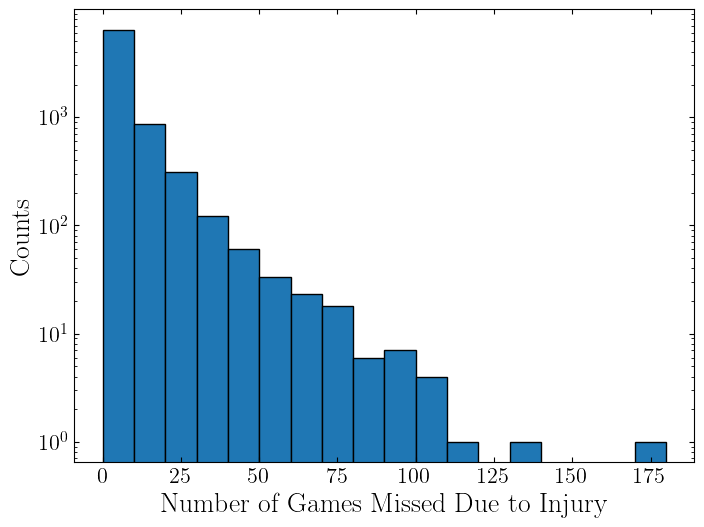

In [11]:
plt.figure(figsize=(8,6))

bins = np.arange(0,190,10)

_ = plt.hist(missed['N_missed'],bins=bins,log=True,edgecolor='k')

plt.xlabel('Number of Games Missed Due to Injury')
plt.ylabel('Counts')

## Look at injuries just of players in our final dataset

In [4]:
injs = pd.read_csv('inj_data_final.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (104,113,122) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
names = injs.Name.unique()

In [13]:
missed_15 = missed[missed['Name'].isin(names)]

In [14]:
mean = missed_15['N_missed'].mean()
std = missed_15['N_missed'].std()

print("The mean time missed due to injury is {:.3f}, with standard deviation {:.3f}".format(mean,std))

The mean time missed due to injury is 5.889, with standard deviation 10.470


Text(0, 0.5, 'Counts')

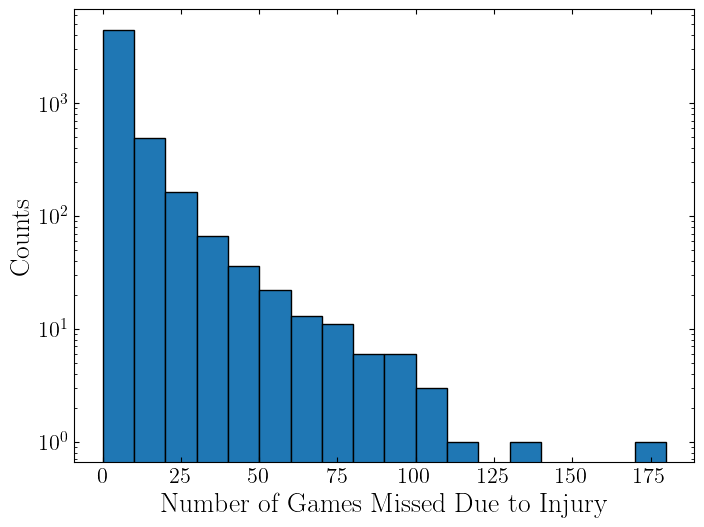

In [17]:
fig = plt.figure(figsize=(8,6))

bins = np.arange(0,190,10)

_ = plt.hist(missed_15['N_missed'],bins=bins,log=True,edgecolor='k')

plt.xlabel('Number of Games Missed Due to Injury')
plt.ylabel('Counts')

In [20]:
fig.savefig('missed_games_fig.png', dpi=300)

## Should games where players are injured count as a played or missed game?

In [19]:
inj_df = pd.read_csv('nba_games_2010_20.csv')
inj_df = inj_df.loc[inj_df['Age'] != 0]
inj_df = inj_df.drop(columns='Unnamed: 0')

In [22]:
grouped = inj_df.groupby(['Name'])
injs_filt = grouped.filter(lambda x: x['MP'].mean()>15)

In [23]:
injs_filt.groupby('Was_Injured?').mean()['MP']

Was_Injured?
0.0    25.015954
1.0    20.383579
Name: MP, dtype: float64

### Only 5 minutes of playing time are lost on average, so resting a player in a game they were injured still counts as a played game